## Credit Card Data Analysis

In order to know which services the bank should improve on to improve customer satisfaction, this project deals with analysis of credit card customer data trying to understand what features would affect customer attrition and building a model using Random Forest, Support Vector Machine and Gradient Boosting to predit customer attrition.

Main steps that will be taken:

>Exploratory Data Analysis 

>Feature Engineering and Selection

>Model Training 

In [29]:
# importing libraries  
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import plotly
import plotly.figure_factory as ff
from plotly.offline import plot,iplot,download_plotlyjs

from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objs as go
import cufflinks as cf

cf.set_config_file(sharing='public',theme='white',offline=True)

import plotly.io as pio
pio.renderers.default = 'colab'

from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.ensemble import  RandomForestClassifier,GradientBoostingClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report,recall_score,f1_score,precision_score,confusion_matrix

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from scipy import stats
from scipy.stats import chi2_contingency
from sklearn.metrics import plot_confusion_matrix

### Reading of the data 

In [2]:
df = pd.read_csv('BankChurners.csv')
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


In [3]:
# removing two categories from documentation

df1 = df.iloc[:, :-2]

## Exploratory Data Analysis

### Checking the numerical and categorical features in the data 

In [4]:
n_features= df1.select_dtypes(include=['float64','int64'])
n_features.sample()

,CLIENTNUM,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
4170,718271958,54,2,34,5,1,4,6401.0,1471,4930.0,0.655,4465,63,0.703,0.23


In [5]:
c_features = df1.select_dtypes(exclude=['float64','int64'])
c_features.sample()

,Attrition_Flag,Gender,Education_Level,Marital_Status,Income_Category,Card_Category
1854,Existing Customer,F,Graduate,Married,Unknown,Blue


### Categorical features visualisation and analysis

In [6]:
# percentage of existing and attried customers

fig = go.Figure(data=[go.Pie(labels=df1['Attrition_Flag'],title='Percentage of Existing and Attrited Customers', pull=[0.2, 0])])

fig.show()

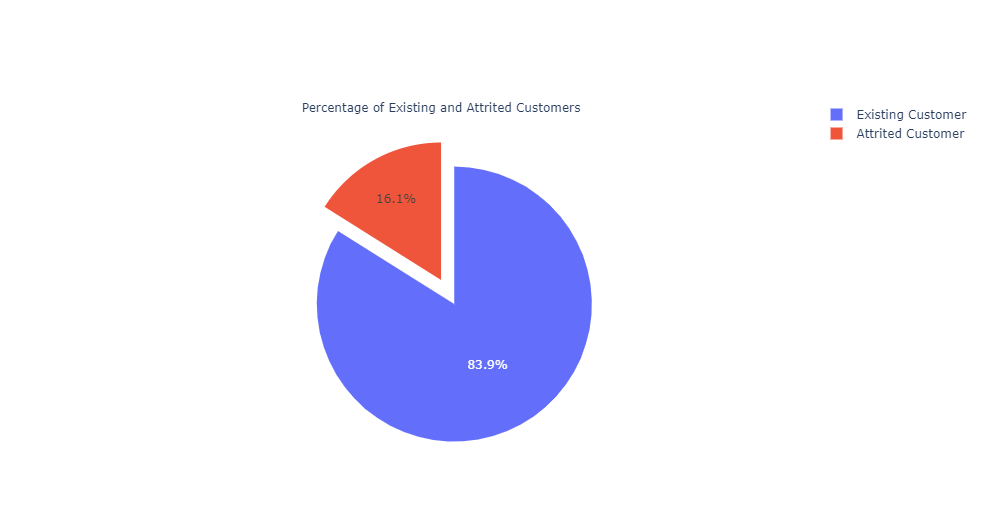

This is not a great ratio. It's unbalanced.
This could cause false negative/positive resilts because the attried data is undersampled.
It has to be dealt with before building the model.

In [7]:
# education level of existing and attried customers

# for existing
plot_edu_e = df1[df1['Attrition_Flag']=='Existing Customer']
plot_edu_e = plot_edu_e['Education_Level'].value_counts().reset_index()
plot_edu_e.columns =['Education_level','Count']
plot_edu_e = plot_edu_e.sort_values('Count')

fig0 = px.bar(
    data_frame=plot_edu_e,
    x="Count",
    y="Education_level",
    color="Education_level",               
    opacity=0.9,                  
    orientation="h",              
    barmode='relative',
    width=700,                   
    height=360,
    title='Education level of existing customers'
    )

# for attried
plot_edu_a = df1[df1['Attrition_Flag']=='Attrited Customer']
plot_edu_a = plot_edu_a['Education_Level'].value_counts().reset_index()
plot_edu_a.columns =['Education_level','Count']
plot_edu_a = plot_edu_a.sort_values('Count')

fig1 = px.bar(
    data_frame=plot_edu_a,
    x="Count",
    y="Education_level",
    color="Education_level",              
    opacity=0.9,                  
    orientation="h",              
    barmode='relative',
    width=700,                 
    height=360,
    title='Education level of attried customers'
    )

fig0.show()
fig1.show()

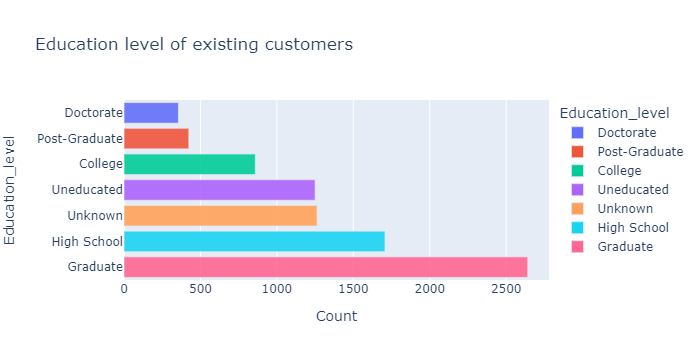

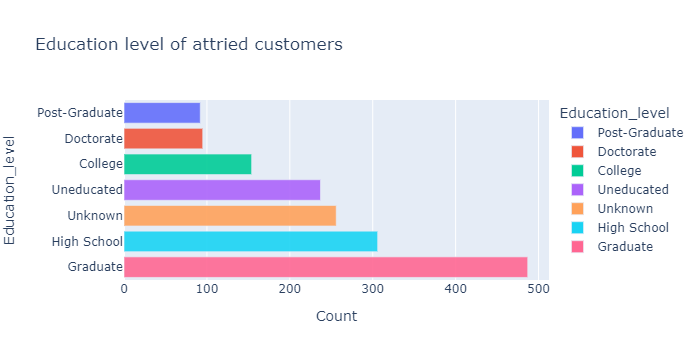

In [8]:
# gender and marital status of existing and attried customers

#for existing
plot_gen_e = df1[df1['Attrition_Flag']=='Existing Customer']
plot_gen_e = plot_gen_e[['Marital_Status','Gender','Attrition_Flag']].groupby(['Marital_Status','Gender']).count().reset_index()
plot_gen_e.columns =['Marital_Status','Gender','Count']
plot_gen_e = plot_gen_e.sort_values('Count')

fig0 = px.bar(
    data_frame=plot_gen_e,
    x="Marital_Status",
    y="Count",
    color="Gender",               # differentiate color of marks
    opacity=0.9,                  # set opacity of markers (from 0 to 1)
    orientation="v",              # 'v','h': orientation of the marks
    barmode='group',
    width=700,                   # figure width in pixels
    height=360,
    title='Marital Status and Gender of existing customers'
    )

# for attried 
plot_gen_a = df1[df1['Attrition_Flag']=='Attrited Customer']
plot_gen_a = plot_gen_a[['Marital_Status','Gender','Attrition_Flag']].groupby(['Marital_Status','Gender']).count().reset_index()
plot_gen_a.columns =['Marital_Status','Gender','Count']
plot_gen_a = plot_gen_a.sort_values('Count')

fig1 = px.bar(
    data_frame=plot_gen_a,
    x="Marital_Status",
    y="Count",
    color="Gender",              
    opacity=0.9,                  
    orientation="v",              
    barmode='group',
    width=700,                   
    height=360,
    title='Marital Status and Gender of attried customers'
    )

fig0.show()
fig1.show()

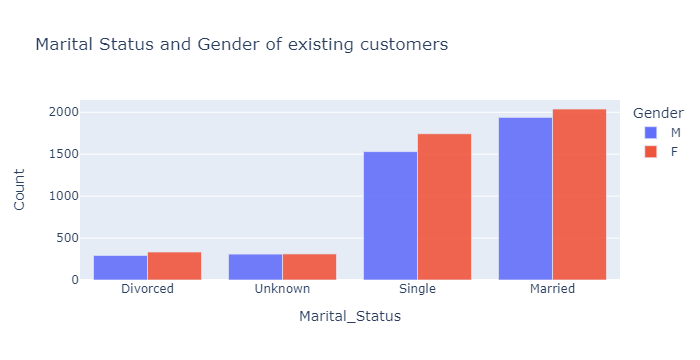

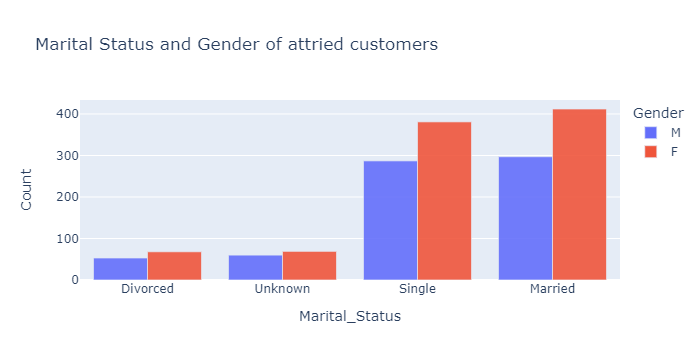

In [9]:
# income level and card category of existing and attried customers

inc_a = df1.loc[df1['Attrition_Flag']=='Attrited Customer','Income_Category']
inc_e = df1.loc[df1['Attrition_Flag']=='Existing Customer','Income_Category']

fig = make_subplots(
    rows=1, cols=2,subplot_titles=('Existing Customers','Attrited Customers','Residuals'),
    vertical_spacing=0.09,
    specs=[[{"type": "pie","rowspan": 1},{"type": "pie"}]]
)


fig.add_trace(
    go.Pie(values=inc_e.value_counts().values,
        labels=['Less than $40k ','$40k - $60k','$80k - $120k','$60k - $80k','Unknown','$120k +']
        ),
    row=1, col=1
)

fig.add_trace(
    go.Pie(values=inc_a.value_counts().values,
        labels=['Less than $40k ','$40k - $60k','$80k - $120k','$60k - $80k','Unknown','$120k +']),
    row=1, col=2
)

fig.update_layout(
    height=400,
    showlegend=True,
    title_text="<b>Income_Category<b>",
)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

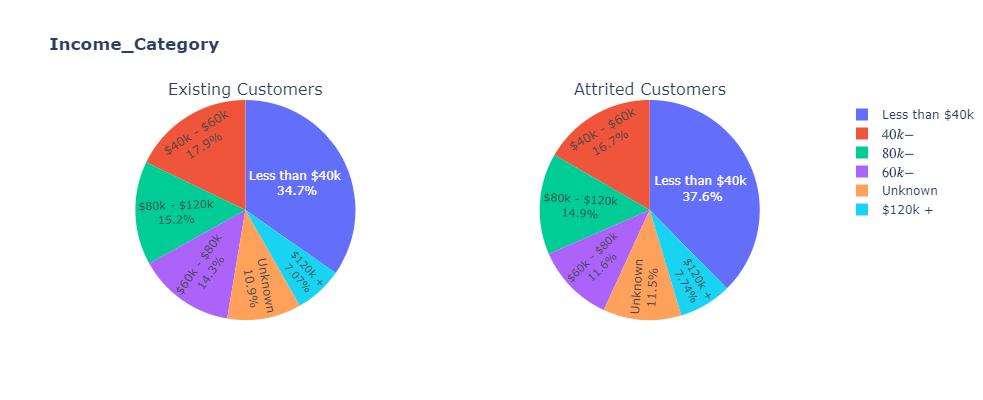

In [10]:
card_a = df1.loc[df1['Attrition_Flag']=='Attrited Customer','Card_Category']
card_e = df1.loc[df1['Attrition_Flag']=='Existing Customer','Card_Category']

fig = make_subplots(
    rows=1, cols=2,subplot_titles=('Existing Customers','Attrited Customers','Residuals'),
    vertical_spacing=0.09,
    specs=[[{"type": "pie","rowspan": 1},{"type": "pie"}]]
)


fig.add_trace(
    go.Pie(values=card_e.value_counts().values,
        labels=['Blue','Silver','Gold','Platinum']
        ),
    row=1, col=1
)

fig.add_trace(
    go.Pie(values=card_a.value_counts().values,
        labels=['Blue','Silver','Gold','Platinum']),
    row=1, col=2
)

fig.update_layout(
    height=600,
    showlegend=True,
    title_text="<b>Card_Category<b>",
)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

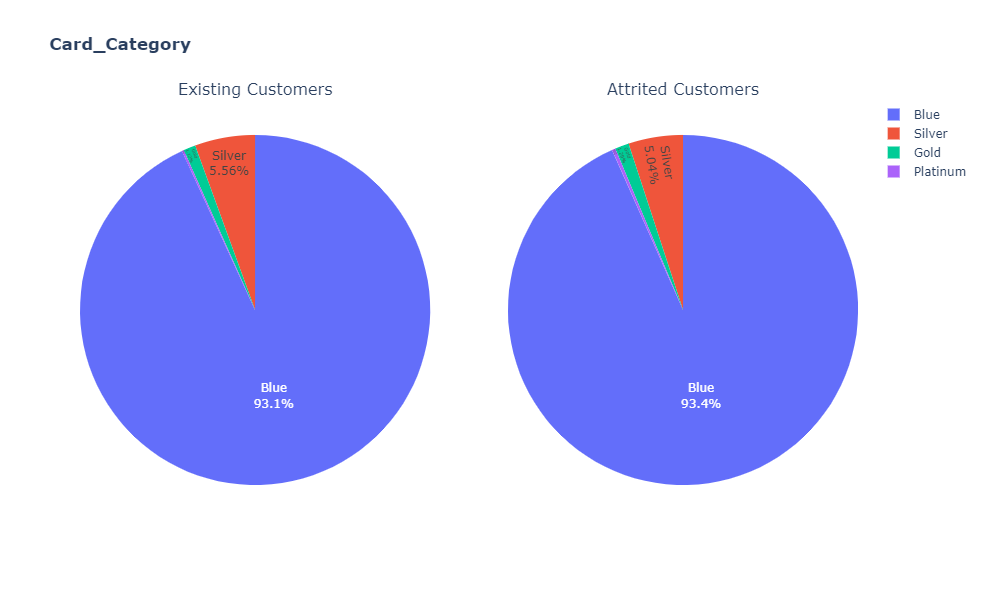

### Numerical features visualisation and analysis

In [11]:
# age

plot_age = df1['Customer_Age'].value_counts().reset_index()
plot_age.columns =['Customer_Age','Count']
plot_age = plot_age.sort_values('Count')

fig = px.bar(
    data_frame=plot_age,
    x="Customer_Age",
    y="Count",
    color="Customer_Age",               
    opacity=0.9,                  
    orientation="v",             
    barmode='relative',
    title='Age of customers'
)

fig.show()

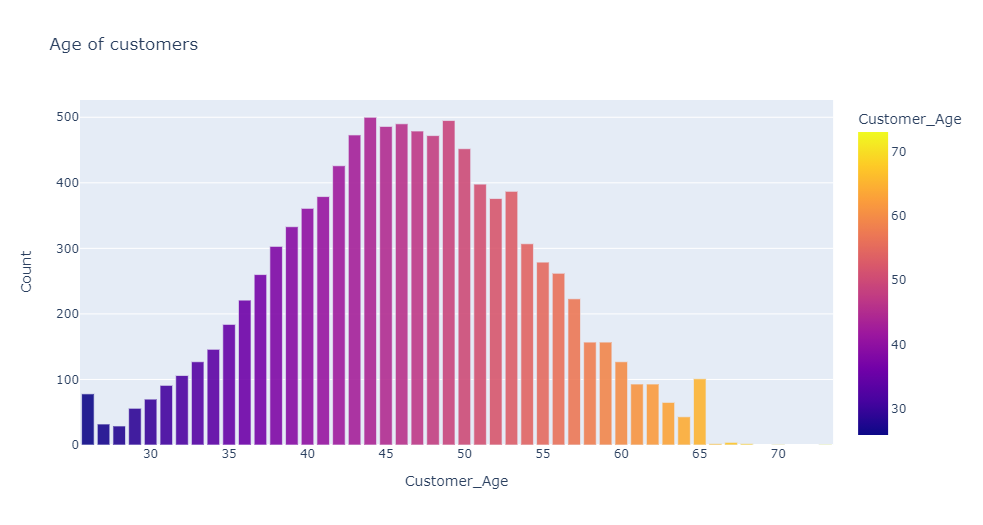

In [12]:
# number of products held by customer

fig = px.histogram(df1, x="Total_Relationship_Count", color="Attrition_Flag",title='Number of products held by customer')
fig.show()

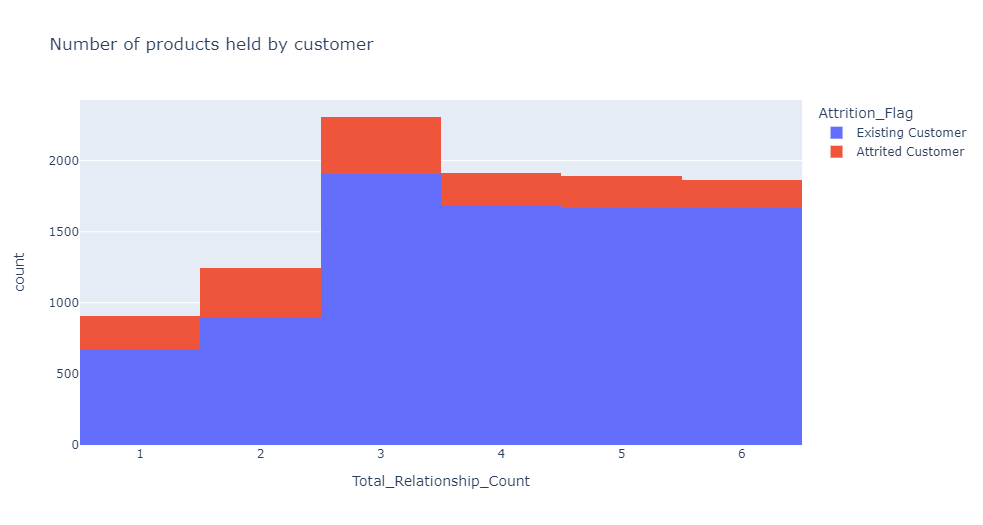

In [13]:
# dependents 
plot_dep = df1['Dependent_count'].value_counts().reset_index()
plot_dep.columns =['Dependent_count','Count']
plot_dep = plot_dep.sort_values('Count')

fig = px.bar(
    data_frame=plot_dep,
    x="Dependent_count",
    y="Count",
    color="Dependent_count",               
    opacity=0.9,                  
    orientation="v",             
    barmode='relative',
    title='Number of dependents'
)

fig.show()

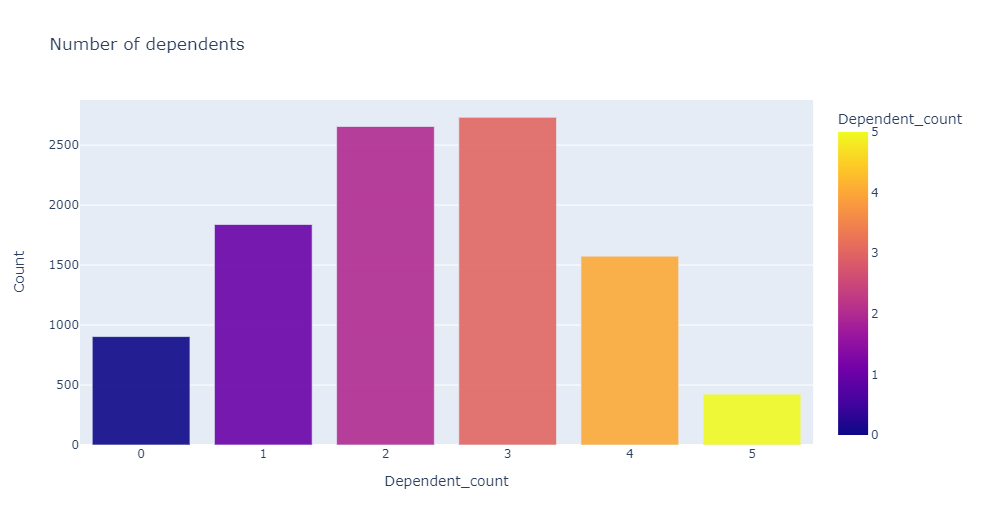

In [14]:
# number of months with no transactions

fig = px.histogram(df1, x="Months_Inactive_12_mon", color="Attrition_Flag",title='Number of months with no transactions in the last year')
fig.show()

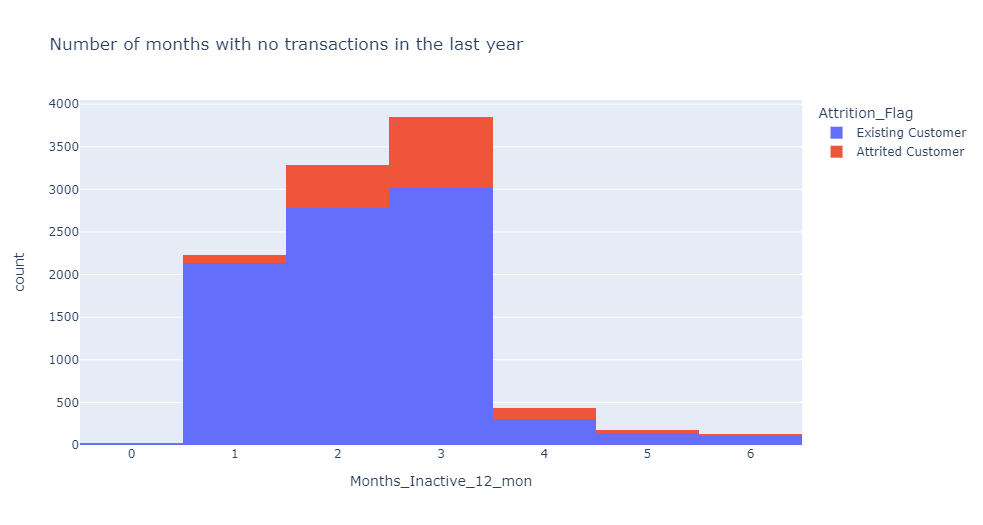

In [15]:
# change in transaction

fig = px.histogram(df1, x="Total_Ct_Chng_Q4_Q1", color="Attrition_Flag",title='Change in transaction number over the last year (Q4 over Q1)')
fig.show()

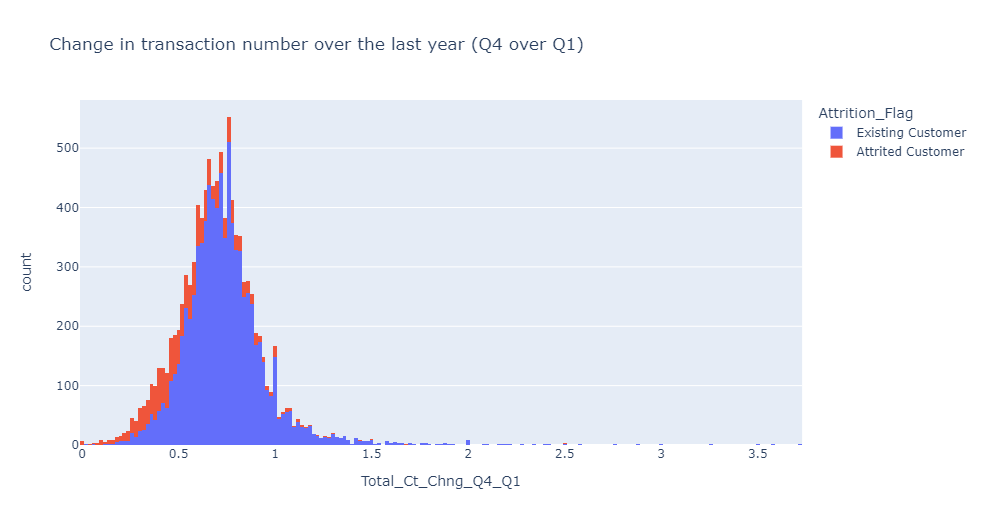

In [16]:
# number of transactions 

fig = px.histogram(df1, x="Total_Trans_Ct", color="Attrition_Flag",title='Number of transactions made in the last year')
fig.update()
fig.show()

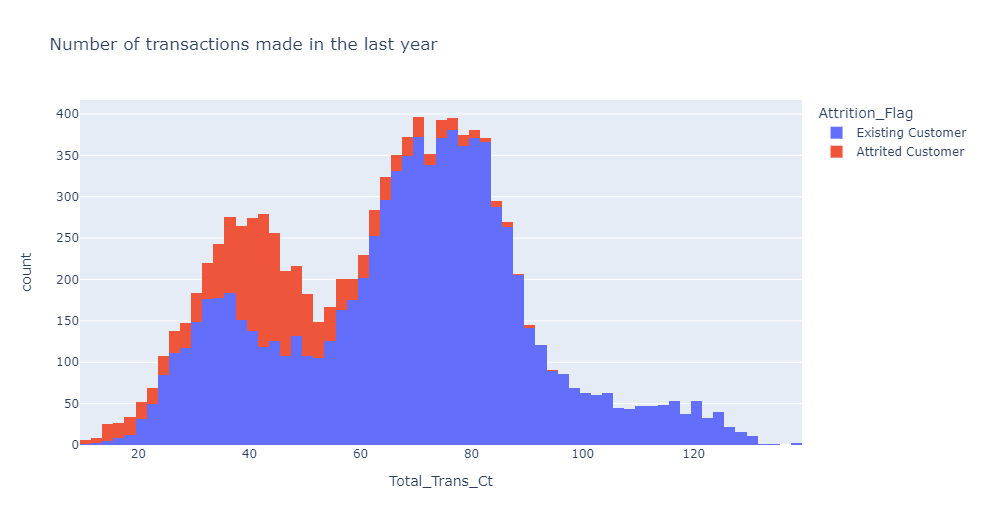

## Feature Engineering and Selection

### Correlation

Because we are working with a dataset with mixed features(categorical and numerical), we just can't use standard correlation function. We have to split the features and measure categorical data correlation with Pearson and numerical data correlation with Cramer's V function.



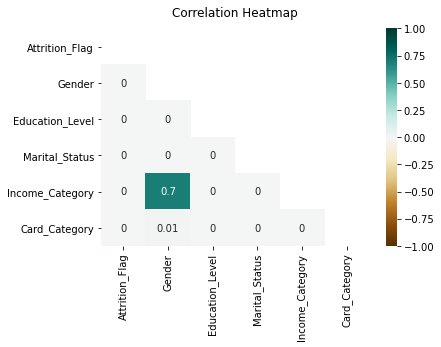

In [17]:
# correlation of categorical data 

label = preprocessing.LabelEncoder()
df_c_encoded = pd.DataFrame() 

for i in c_features.columns :
  df_c_encoded[i]=label.fit_transform(c_features[i])


def cramers_V(var1,var2) :
  crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None))
  stat = chi2_contingency(crosstab)[0] 
  obs = np.sum(crosstab) 
  mini = min(crosstab.shape)-1 
  return (stat/(obs*mini))

rows= []

for var1 in df_c_encoded:
  col = []
  for var2 in df_c_encoded :
    cramers =cramers_V(df_c_encoded[var1], df_c_encoded[var2]) 
    col.append(round(cramers,2))
  rows.append(col)
  
cramers_results = np.array(rows)
cramerv_matrix = pd.DataFrame(cramers_results, columns = df_c_encoded.columns, index =df_c_encoded.columns)
mask = np.triu(np.ones_like(cramerv_matrix, dtype=bool))
cat_heatmap = sns.heatmap(cramerv_matrix, mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
cat_heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

From the heatmap we can tell that categorical columns are not correlated with customer churn by themselves.
Therefore building an accurate model without considering the numerical values is impossible.

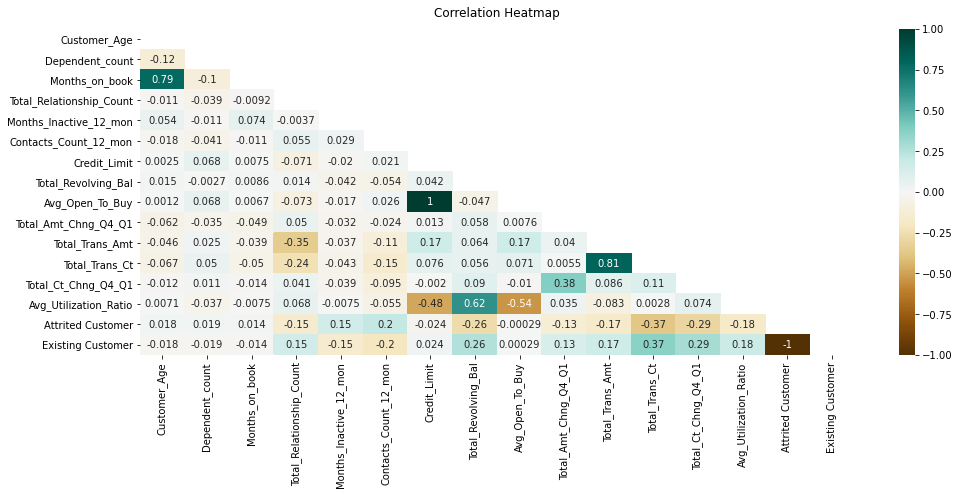

In [18]:
# correlation oh numerical data

n_features['Attrition_Flag']=df1.loc[:,'Attrition_Flag']
oh=pd.get_dummies(n_features['Attrition_Flag'])
n_features=n_features.drop(['Attrition_Flag'],axis=1)
n_features=n_features.drop(['CLIENTNUM'],axis=1)
n_features=n_features.join(oh)
n_features.head()

num_corr=n_features.corr()
plt.figure(figsize=(16, 6))
mask = np.triu(np.ones_like(num_corr, dtype=bool))
num_heatmap = sns.heatmap(num_corr, mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
num_heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

Better correlation measurements can be seen.
The correlation coefficient of attrited and existing customer to all feature columns are identical in numbers, with mirroring signs.
Lets take a closer look.

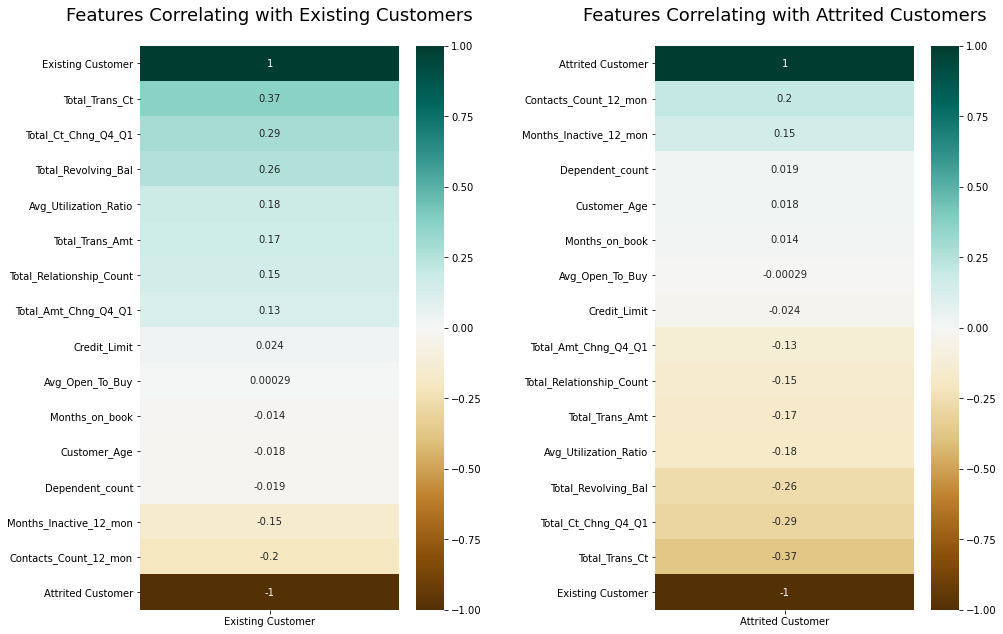

In [19]:
fig, ax=plt.subplots(ncols=2,figsize=(15, 10))

heatmap = sns.heatmap(num_corr[['Existing Customer']].sort_values(by='Existing Customer', ascending=False), ax=ax[0],vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Existing Customers', fontdict={'fontsize':18}, pad=25);
heatmap = sns.heatmap(num_corr[['Attrited Customer']].sort_values(by='Attrited Customer', ascending=False), ax=ax[1],vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Attrited Customers', fontdict={'fontsize':18}, pad=25);

fig.tight_layout(pad=5)

We can therefore conclude that,
Credit Limit, Average open to buy, Age and Dependent count
are not correlated to customer churn


In [20]:
# discard the features mentioned above to build an accurate model.

df_model=df1
df_model=df_model.drop(['CLIENTNUM','Credit_Limit','Customer_Age','Avg_Open_To_Buy','Months_on_book','Dependent_count'],axis=1)
df_model.head()

,Attrition_Flag,Gender,Education_Level,Marital_Status,Income_Category,Card_Category,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Total_Revolving_Bal,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,Existing Customer,M,High School,Married,$60K - $80K,Blue,5,1,3,777,1.335,1144,42,1.625,0.061
1,Existing Customer,F,Graduate,Single,Less than $40K,Blue,6,1,2,864,1.541,1291,33,3.714,0.105
2,Existing Customer,M,Graduate,Married,$80K - $120K,Blue,4,1,0,0,2.594,1887,20,2.333,0.000
3,Existing Customer,F,High School,Unknown,Less than $40K,Blue,3,4,1,2517,1.405,1171,20,2.333,0.760
4,Existing Customer,M,Uneducated,Married,$60K - $80K,Blue,5,1,0,0,2.175,816,28,2.500,0.000


In [21]:
# convert the categorical features into binary with one hot encoding

df_model['Attrition_Flag'] = df_model['Attrition_Flag'].map({'Existing Customer': 1, 'Attrited Customer': 0})
df_oh=pd.get_dummies(df_model)
df_oh['Attrition_Flag'] = df_oh['Attrition_Flag'].map({1: 'Existing Customer', 0: 'Attrited Customer'})
list(df_oh.columns)

['Attrition_Flag',
 'Total_Relationship_Count',
 'Months_Inactive_12_mon',
 'Contacts_Count_12_mon',
 'Total_Revolving_Bal',
 'Total_Amt_Chng_Q4_Q1',
 'Total_Trans_Amt',
 'Total_Trans_Ct',
 'Total_Ct_Chng_Q4_Q1',
 'Avg_Utilization_Ratio',
 'Gender_F',
 'Gender_M',
 'Education_Level_College',
 'Education_Level_Doctorate',
 'Education_Level_Graduate',
 'Education_Level_High School',
 'Education_Level_Post-Graduate',
 'Education_Level_Uneducated',
 'Education_Level_Unknown',
 'Marital_Status_Divorced',
 'Marital_Status_Married',
 'Marital_Status_Single',
 'Marital_Status_Unknown',
 'Income_Category_$120K +',
 'Income_Category_$40K - $60K',
 'Income_Category_$60K - $80K',
 'Income_Category_$80K - $120K',
 'Income_Category_Less than $40K',
 'Income_Category_Unknown',
 'Card_Category_Blue',
 'Card_Category_Gold',
 'Card_Category_Platinum',
 'Card_Category_Silver']

## Model Training 

### Balancing the training dataset

To balance the dataset we will utilize SMOTE.
We will split the training and test data.
SMOTE will onlt be applied to the training dataset.

In [22]:
# balancing the training dataset

X = df_oh.loc[:, df_oh.columns != 'Attrition_Flag']
y = df_oh['Attrition_Flag']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [23]:
sm = SMOTE(sampling_strategy='minority', k_neighbors=20, random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

### Random forest classifier 

In [24]:
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train_res, y_train_res)

RandomForestClassifier()

### Support Vector Machine

In [25]:
svm_clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
svm_clf.fit(X_train_res, y_train_res)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

### Gradient boosting 

In [26]:
gb_clf=GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=42)
gb_clf.fit(X_train_res, y_train_res)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=42)

### First prediction and evaluation

In [27]:
# first prediction

y_rf=rf_clf.predict(X_test)
y_svm=svm_clf.predict(X_test)
y_gb=gb_clf.predict(X_test)

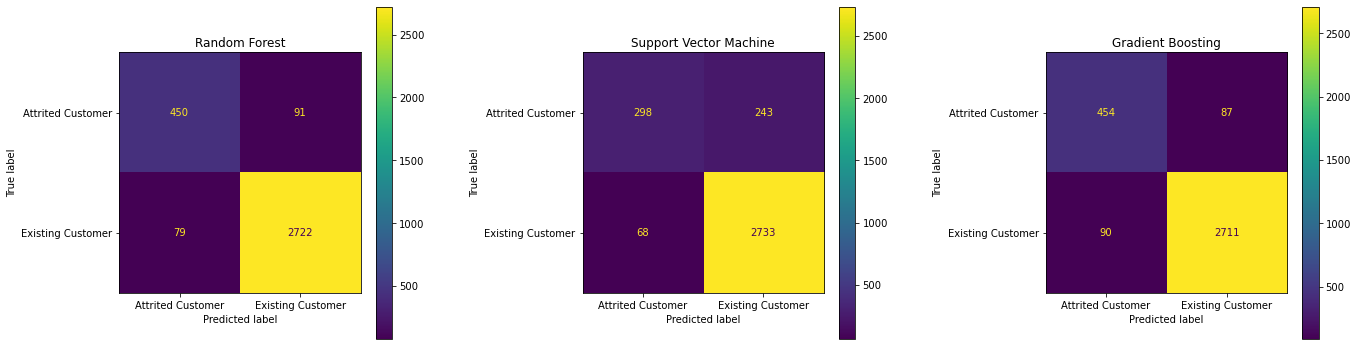

In [30]:
# first evaluation
fig,ax=plt.subplots(ncols=3, figsize=(20,6))
plot_confusion_matrix(rf_clf, X_test, y_test, ax=ax[0])
ax[0].title.set_text('Random Forest')
plot_confusion_matrix(svm_clf, X_test, y_test, ax=ax[1])
ax[1].title.set_text('Support Vector Machine')
plot_confusion_matrix(gb_clf, X_test, y_test, ax=ax[2])
ax[2].title.set_text('Gradient Boosting')
fig.tight_layout(pad=5)

In [31]:
print('Random Forest Classifier')
print(classification_report(y_test, y_rf))
print('------------------------')
print('Support Vector Machine')
print(classification_report(y_test, y_svm))
print('------------------------')
print('Gradient Boosting')
print(classification_report(y_test, y_gb))

Random Forest Classifier
                   precision    recall  f1-score   support

Attrited Customer       0.85      0.83      0.84       541
Existing Customer       0.97      0.97      0.97      2801

         accuracy                           0.95      3342
        macro avg       0.91      0.90      0.91      3342
     weighted avg       0.95      0.95      0.95      3342

------------------------
Support Vector Machine
                   precision    recall  f1-score   support

Attrited Customer       0.81      0.55      0.66       541
Existing Customer       0.92      0.98      0.95      2801

         accuracy                           0.91      3342
        macro avg       0.87      0.76      0.80      3342
     weighted avg       0.90      0.91      0.90      3342

------------------------
Gradient Boosting
                   precision    recall  f1-score   support

Attrited Customer       0.83      0.84      0.84       541
Existing Customer       0.97      0.97      0.97   

From both the confusion matrix and classification report that random forest and gradient boosting are the best with recall scores above 85% 

### Tuning hyperparameters

Let's try and increase the model accuracy of the random forest and gradient boosting

In [32]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
#rf_random = RandomizedSearchCV(estimator = rf_clf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
#rf_random.fit(X_train_res, y_train_res)
#print(rf_random.best_params_)

Random Forest Classifier (Optimized)
                   precision    recall  f1-score   support

Attrited Customer       0.87      0.82      0.84       541
Existing Customer       0.96      0.98      0.97      2801

         accuracy                           0.95      3342
        macro avg       0.92      0.90      0.91      3342
     weighted avg       0.95      0.95      0.95      3342



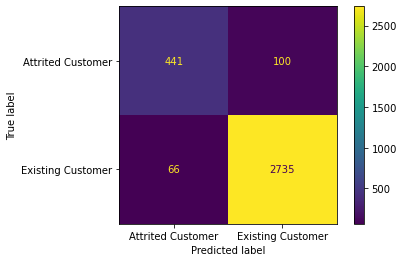

In [33]:
rf_clf_opt= RandomForestClassifier(n_estimators=750, min_samples_split=2, min_samples_leaf=1, 
                            max_features='auto', max_depth=50, bootstrap=False)
rf_clf_opt.fit(X_train_res,y_train_res)
y_rf_opt=rf_clf_opt.predict(X_test)
print('Random Forest Classifier (Optimized)')
print(classification_report(y_test, y_rf_opt))
_rf_opt=plot_confusion_matrix(rf_clf_opt, X_test, y_test)

In [ ]:
#param_test1 = {'n_estimators':range(20,81,10)}
#gsearch1 = GridSearchCV(
#estimator = GradientBoostingClassifier(learning_rate=1.0, min_samples_split=500,min_samples_leaf=50,max_depth=8,max_features='sqrt',subsample=0.8,random_state=10), 
#param_grid = param_test1, scoring='roc_auc',n_jobs=4, cv=5)
#gsearch1.fit(X_train_res,y_train_res)
#print(gsearch1.best_params_)

Gradient Boosting (Optimized)
                   precision    recall  f1-score   support

Attrited Customer       0.86      0.85      0.86       541
Existing Customer       0.97      0.97      0.97      2801

         accuracy                           0.95      3342
        macro avg       0.92      0.91      0.91      3342
     weighted avg       0.95      0.95      0.95      3342

0.8521256931608133


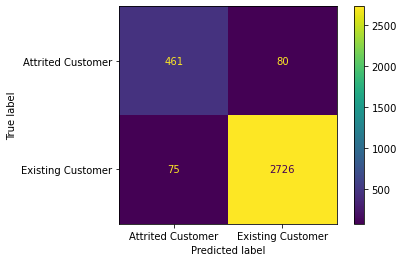

In [34]:
gb_clf_opt=GradientBoostingClassifier(n_estimators=80,learning_rate=1.0, min_samples_split=500,min_samples_leaf=50,max_depth=8,max_features='sqrt',subsample=0.8,random_state=10)
gb_clf_opt.fit(X_train_res,y_train_res)
y_gb_opt=gb_clf_opt.predict(X_test)
print('Gradient Boosting (Optimized)')
print(classification_report(y_test, y_gb_opt))
print(recall_score(y_test,y_gb_opt,pos_label="Attrited Customer"))
_gbopt=plot_confusion_matrix(gb_clf_opt, X_test, y_test)

## Conclusion

The model should be considered adequate as there was no significant change to the accuracy and has 95% accuracy and a 84% recall score.

However the performance is unkown in the real world since we used SMOTE to adjust the data set.